In [7]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
import json
import io
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import py3Dmol
import copy

from rdkit.Geometry import Point3D

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import pickle
from support_mvp.backup_plot_diagram.data_handler import renamed_load

# For highlight colors
from matplotlib.colors import ColorConverter
import matplotlib.ticker as mticker

# Stuff for changing rdkit drawing view: 
#IPythonConsole.drawOptions.addAtomIndices = True
#IPythonConsole.molSize = 500,500
#IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

HARTREE2EV = 27.2114
HARTREE2KCAL = 627.51
kcal = 627.51
ev = 27.2114


# Alternate way 
#with open('benzene.svg','w') as f:
#    f.write(img.data)
#img = Chem.Draw.MolsToGridImage([m], useSVG=True)
    

In [8]:
dft_base = Path('/home/magstr/dft_data')
img_dir = Path('imgs')

### Functions

In [9]:
def draw_mol(
    mol,
    width=900,
    height=900,
    Hs=False,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
    hit_ats=None,
    gen_struct=None,
    trajectory=False,
):
    p = py3Dmol.view(width=width, height=height)
    
    if isinstance(mol, str):
        xyz_f = open(mol)
        line = xyz_f.read()
        xyz_f.close()
        p.addModel(line, "xyz")
    else:
        if multipleConfs:
            for conf in mol.GetConformers():
                mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
                p.addModel(mb, "sdf")
        else:
            mb = Chem.MolToMolBlock(mol)
            p.addModel(mb, "sdf")
        
    p.setStyle({"stick": {"radius": 0.2}, "sphere":
                {"radius": 0.3}})
    if atomlabel:
        p.addPropertyLabels("index")  # ,{'elem':'H'}
    p.zoomTo()
    p.update()

In [10]:
def single_atom_remover(mol, idx):
    """Function that removes an atom at specified idx.

    Args:
        mol (Chem.rdchem.Mol): The mol to remove substruct on
        pattern (Chem.rdchem.Mol): mol object to remove from the input mol

    Returns:
        Chem.rdchem.Mol: The ouput mol with the atom removed
    """
    res = Chem.RWMol(mol)
    res.BeginBatchEdit()
    res.RemoveAtom(idx)
    res.CommitBatchEdit()
    Chem.SanitizeMol(res)
    return res.GetMol()

In [11]:
def remove_NH3(mol):
    """Remove NH3 group on mol."""

    # Substructure match the NH3
    NH3_match = Chem.MolFromSmarts("[NH3]")
    NH3_match = Chem.AddHs(NH3_match)
    removed_mol = Chem.DeleteSubstructs(mol, NH3_match)

    return removed_mol

CC(C)(N)CCC1CCCCC1## Core images

In [13]:
converged_file = Path('../data/converged_reaction_profiles.pkl')

with open(converged_file, "rb") as f:
    conf = renamed_load(f)

In [14]:
for i in conf:
    print(i.smiles)

CCCN1CCCC(N)(C2CCCC2)C1
CCCOC(=O)NCC1(N)CCCCC1
C=C(C)CC(C)(C)N
CC(=O)c1cc(O)c(C(=O)CN)cc1O
CC(=O)c1ccc(F)c(C(=O)CN)c1
CC(=O)c1ccc(F)c(C(=O)N=CN)c1
N#Cc1ccnc(C#N)c1N
N#Cc1ccnc(C(=O)Cl)c1N
N#Cc1cnc(C#N)c(N)c1
N#Cc1ncc(C(=O)CO)cc1N
N#Cc1ncc(CC(=O)O)cc1N
NC1(CCCCCl)CCCCC1
NC=NC(=O)c1cccc(Br)c1
NCC=Cc1ncnc2ccccc12
NCCc1ncnc2ccccc12
Nc1ccccc1N=CC(=O)Cl
NCCCOc1ccnc2cccnc12
NCCCOc1ncnc2cccnc12
NCCCc1ncnc2ccccc12
NCCOC(=O)c1ncnc2ccccc12
CC(=O)Nc1ccc(F)c(C(=O)Cc2ccnc(N)c2)c1
CC(C)(N)CCC1CCCCC1
CC(N)Cc1ccc(CCl)cc1
CC(N)Cc1ccc(Cc2ccccc2)cc1


In [16]:
# My candidate molecules so far
# C1 2
# C2 -5 
# C3 9 
# C4 -7
# C5 -1 
# C6 -3
# C7 -2
# C8 8 
# C9 6
# C10 7 
# C11 1
# C12 -4

In [44]:
idx = 7

In [45]:
# Replace tricky primary amines in the frag:
prim_match = Chem.MolFromSmarts("[NX3;H2]")
rm = Chem.ReplaceSubstructs(
                            conf[idx].rdkit_mol,
                            prim_match,
                            Chem.MolFromSmiles("[1*]"),
                            replaceAll=True,
                        )[0]
rm
Chem.Draw.MolToFile(rm, img_dir/'tmp.svg')

In [46]:
with open('coordinates.xyz', "w+") as f:
    f.write(Chem.MolToXYZBlock(conf[idx].optimized_mol2))

In [47]:
scoring_to_keys = {'rdkit_embed_scoring':('Mo_N2_NH3', 'Mo_NH3'),'rdkit_embed_scoring_NH3toN2':('Mo_NH3', 'Mo_N2'),'rdkit_embed_scoring_NH3plustoNH3':('Mo_NH3+', 'Mo_NH3')}

In [48]:
def correct_lines(xyz_coordinates, key):
    
    if key =='Mo_N2_NH3':
        
        xyz_coordinates.insert(23,xyz_coordinates.pop(-6))
        xyz_coordinates.insert(24,xyz_coordinates.pop(-5))
        xyz_coordinates.insert(25,xyz_coordinates.pop(-4))
        xyz_coordinates.insert(26,xyz_coordinates.pop(-3))
        xyz_coordinates.insert(27,xyz_coordinates.pop(-2))
        xyz_coordinates.insert(28,xyz_coordinates.pop(-1))
    elif key =='Mo_N2':
        pass
    elif (key == 'Mo_NH3') | (key == 'Mo_NH3+'):
        xyz_coordinates.insert(23,xyz_coordinates.pop(-4))
        xyz_coordinates.insert(24,xyz_coordinates.pop(-3))
        xyz_coordinates.insert(25,xyz_coordinates.pop(-2))
        xyz_coordinates.insert(26,xyz_coordinates.pop(-1))
    return xyz_coordinates

In [49]:
def lines_to_xyz(file):
    
    atomic_symbols = []
    xyz_coordinates = []
    for line_number, line in enumerate(file):
        if line_number == 0:
            num_atoms = int(line)
        elif line_number == 1:
            comment = line  # might have useful information
        else:
            atomic_symbol, x, y, z = line.split()
            atomic_symbols.append(atomic_symbol)
            xyz_coordinates.append([float(x), float(y), float(z)])
    
    return xyz_coordinates

In [50]:
def fix_xyz_lines(mol, keys):


    file = conf[idx].reaction_profile_final_structs[keys[0]]

    xyz_coordinates = lines_to_xyz(file)

    mol = copy.deepcopy(conf[idx].optimized_mol1)
    mol.RemoveAllConformers()

    xyz_coordinates = correct_lines(xyz_coordinates, keys[0])

    # from https://github.com/rdkit/rdkit/issues/2413
    conformer = Chem.Conformer()
    # in principal, you should check that the atoms match
    for i in range(mol.GetNumAtoms()):
        x, y, z = xyz_coordinates[i]
        conformer.SetAtomPosition(i, Point3D(x, y, z))
    mol.AddConformer(conformer, assignId=True)
    conf[idx].optimized_pbe_mol1 = mol 
    
    
    file = conf[idx].reaction_profile_final_structs[keys[1]]
    xyz_coordinates = lines_to_xyz(file)
    mol = copy.deepcopy(conf[idx].optimized_mol2)
    mol.RemoveAllConformers()

    correct_lines(xyz_coordinates, keys[1])

    # from https://github.com/rdkit/rdkit/issues/2413
    conformer = Chem.Conformer()
    # in principal, you should check that the atoms match
    for i in range(mol.GetNumAtoms()):
        x, y, z = xyz_coordinates[i]
        conformer.SetAtomPosition(i, Point3D(x, y, z))
    mol.AddConformer(conformer, assignId=True)
    conf[idx].optimized_pbe_mol2 = mol 
    

    return mol

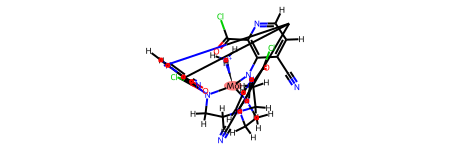

In [51]:

fix_xyz_lines(conf[idx], scoring_to_keys[conf[idx].scoring_function])

In [57]:
Chem.MolToMolFile(conf[idx].optimized_pbe_mol2, 'nh3.mol')

In [52]:
draw_mol(conf[idx].optimized_pbe_mol1)
draw_mol(conf[idx].optimized_pbe_mol2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

CC(C)(N)CCC1CCCCC1interaction# Debug lines